### **Section 1: Data Prep**

In [1]:
!pip install m2cgen

#### **1.1 Data Loading**

In [2]:
# Install the Updated Version of SKLearn if Nedded
!pip install scikit-learn==0.24.2

^C
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from PIL import Image as im
import sys
sys.setrecursionlimit(2147483647)
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
style.use("ggplot")


In [32]:


# Load Training Data and Evaluation Data.
def data_prep_multiclass(path_prefix):
    results = []
    for name in ["eval", "train"]:
        csv = pd.read_csv(f"{path_prefix}{name}.csv")
        csv = csv.iloc[:, 0:258]
        csv.dropna(inplace=True)
        csv.drop_duplicates(inplace=True)
        csv.reset_index(drop=True,inplace=True)
        results.append(csv)
    return results

In [35]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from PIL import Image

transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_csv, eval_csv = data_prep_multiclass("data/1126")
assert len(train_csv.label.unique()) == len(eval_csv.label.unique())
num_class = len(train_csv.label.unique())

class PandasDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.transform = transform
        self.dataframe = dataframe
        self.labels = self.dataframe.label.to_numpy().astype(float)
        self.data = self.dataframe.iloc[:, 1:257].to_numpy()
        self.data = (self.data - self.data.mean(1, keepdims=True)) / (self.data.std(1, keepdims=True) + 1e-8)
        # self.data = (self.data - self.data.mean(0, keepdims=True)) / (self.data.std(0, keepdims=True) + 1e-8)
        self.data = self.data.reshape(-1, 1, 16, 16).astype(float)
        print(self.labels.shape)
        print(self.data.shape)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img = self.data[index, ...]
        if self.transform:
            img = self.transform(Image.fromarray(img[0, ...]))
        target = float(self.labels[index])
        return img, target

batch_size_train = 1280
batch_size_test = 1280
total_size  = len(train_csv)
train_size = int(total_size * 0.8)
test_size = total_size - train_size
# train_dataset, test_dataset = random_split(PandasDataset(train_csv, transform=transforms),
train_dataset, test_dataset = random_split(PandasDataset(train_csv, transform=None),
                                           [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
eval_loader = torch.utils.data.DataLoader(PandasDataset(eval_csv,transform=None), 
                                          batch_size=len(eval_csv), shuffle=False)
train_csv.label.unique()

(3565,)
(3565, 1, 16, 16)
(35166,)
(35166, 1, 16, 16)


array([0., 1., 2., 3., 4., 5., 6.])

torch.Size([1280, 1, 16, 16])
torch.Size([1280])


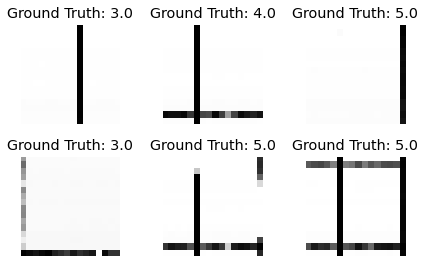

In [26]:
examples = enumerate(train_loader)
idx, example_data = next(examples)
imgs, labels = example_data
print(imgs.shape)
print(labels.shape)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

#### **2.2 NN Training**

In [27]:
class TwoDCNN(nn.Module):
  def __init__(self, config=[1, 4, 8, 16, 32], num_class=7, dropout=0.5):
    super(TwoDCNN, self).__init__()
    
    modules = []
    for i, dim in enumerate(config[1:-1]):
      modules += [
        nn.Conv2d(config[i], dim, 3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(dim),
        nn.Dropout(dropout),
        nn.MaxPool2d(2)
      ]
    modules += [
      nn.Conv2d(config[-2], config[-1], 3, padding=1),
      nn.BatchNorm2d(config[-1]),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(config[-1], num_class),
    ]
    self.net = nn.Sequential(*modules)
    

  def forward(self, x):
    for layer in self.net:
        x = layer(x)
    return x

criterion = nn.CrossEntropyLoss()

In [28]:
import torch
import torch.nn as nn

from einops import rearrange


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 1, 32, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)
    
    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x



In [29]:
# our mobilevit
class TFTwoDCNN(nn.Module):
  def __init__(self, config=[1, 4, 8, 16, 16], maxpool=[True, True, True], 
               num_class=7, dropout=0.5):
    super(TFTwoDCNN, self).__init__()
    
    modules = []
    for i, dim in enumerate(config[1:-1]):
      modules += [
        nn.Conv2d(config[i], dim, 3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(dim),
        nn.Dropout(dropout)
      ]
      if maxpool[i]:
        modules += [nn.MaxPool2d(2)]
      modules += [MobileViTBlock(dim, 2, dim, 3, (2, 2), dim*3)]
    modules += [
      nn.Conv2d(config[-2], config[-1], 3, padding=1),
      nn.BatchNorm2d(config[-1]),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(config[-1], num_class),
    ]
    self.net = nn.Sequential(*modules)
    

  def forward(self, x):
    for layer in self.net:
        x = layer(x)
    return x

criterion = nn.CrossEntropyLoss()


In [36]:
def test_eval(model, test_loader, eval_loader):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.eval()
  acc = {}
  with torch.no_grad():
    # for name, loader in [("test", test_loader), ("eval", eval_loader)]:
    for name, loader in [("test", test_loader)]:
      correct_count, all_count = 0, 0
      for images, labels in loader:
        images = images.type(torch.float).to(device)
        labels = labels.type(torch.long).to(device)
        out = model(images)
        pred = torch.argmax(out, dim=1)
        correct_count += (labels == pred).sum().item()
        all_count += images.shape[0]
      acc[name] = correct_count / all_count
      print(f"On %s set: Acc %.3f" % (
        name, acc[name]))
  # return acc["test"], acc["eval"]
  return acc["test"], 0

def train(model, train_loader, test_loader, eval_loader, epochs, lr):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
  eval_acc_list = []
  train_acc_list = []
  test_acc_list = []
  for e in range(epochs):
    model.train()
    running_loss = 0
    ct, all_count = 0, 0
    for images, labels in train_loader:
      optimizer.zero_grad()
      images = images.type(torch.float).to(device)
      labels = labels.type(torch.long).to(device)
      output = model(images)
      loss = criterion(output, labels)
      pred = torch.argmax(output, dim=1)
      ct += (labels == pred).sum().item()
      all_count += images.shape[0]
      loss.backward()

      optimizer.step()
      ct += 1
      running_loss += loss.item()
    train_acc_list.append(ct / all_count)
    print("Epoch {} - Training loss: {:.3f}".format(e+1, running_loss/len(train_loader)))
    print(f"On train set: Acc %.3f" % (train_acc_list[-1]))
    test_acc, eval_acc = test_eval(model, test_loader, eval_loader)
    eval_acc_list.append(test_acc)
    # test_acc_list.append(eval_acc)
  print(f"Best Train Acc: {max(train_acc_list)}")
  print(f"Best Test Acc: {max(eval_acc_list)}")
  # print(f"Best Eval Acc: {max(test_acc_list)}")


In [37]:
model = TwoDCNN(num_class=num_class, dropout=0.01)
train(model, train_loader, test_loader, eval_loader, 80, 0.05)

Epoch 1 - Training loss: 1.674
On train set: Acc 0.291
On test set: Acc 0.217
Epoch 2 - Training loss: 1.054
On train set: Acc 0.592
On test set: Acc 0.474
Epoch 3 - Training loss: 0.805
On train set: Acc 0.706
On test set: Acc 0.546
Epoch 4 - Training loss: 0.676
On train set: Acc 0.750
On test set: Acc 0.640
Epoch 5 - Training loss: 0.596
On train set: Acc 0.781
On test set: Acc 0.683
Epoch 6 - Training loss: 0.557
On train set: Acc 0.793
On test set: Acc 0.746
Epoch 7 - Training loss: 0.512
On train set: Acc 0.797
On test set: Acc 0.753
Epoch 8 - Training loss: 0.461
On train set: Acc 0.816
On test set: Acc 0.743
Epoch 9 - Training loss: 0.436
On train set: Acc 0.835
On test set: Acc 0.801
Epoch 10 - Training loss: 0.377
On train set: Acc 0.864
On test set: Acc 0.783
Epoch 11 - Training loss: 0.382
On train set: Acc 0.854
On test set: Acc 0.801
Epoch 12 - Training loss: 0.367
On train set: Acc 0.854
On test set: Acc 0.808
Epoch 13 - Training loss: 0.345
On train set: Acc 0.874
On te

In [39]:
model = TFTwoDCNN(num_class=num_class, dropout=0.01)
train(model, train_loader, test_loader, eval_loader, 120, 0.05)

Epoch 1 - Training loss: 1.976
On train set: Acc 0.225
On test set: Acc 0.114
Epoch 2 - Training loss: 1.562
On train set: Acc 0.444
On test set: Acc 0.245
Epoch 3 - Training loss: 1.331
On train set: Acc 0.509
On test set: Acc 0.278
Epoch 4 - Training loss: 1.118
On train set: Acc 0.560
On test set: Acc 0.296
Epoch 5 - Training loss: 0.970
On train set: Acc 0.645
On test set: Acc 0.317
Epoch 6 - Training loss: 0.885
On train set: Acc 0.702
On test set: Acc 0.342
Epoch 7 - Training loss: 0.772
On train set: Acc 0.725
On test set: Acc 0.372
Epoch 8 - Training loss: 0.744
On train set: Acc 0.749
On test set: Acc 0.412
Epoch 9 - Training loss: 0.689
On train set: Acc 0.758
On test set: Acc 0.429
Epoch 10 - Training loss: 0.667
On train set: Acc 0.769
On test set: Acc 0.474
Epoch 11 - Training loss: 0.619
On train set: Acc 0.757
On test set: Acc 0.461
Epoch 12 - Training loss: 0.582
On train set: Acc 0.795
On test set: Acc 0.492
Epoch 13 - Training loss: 0.581
On train set: Acc 0.777
On te